## Credit Card Transaction Fraud Detection

<img src="fraud.png" alt="Drawing" style="width: 300px;"/>

You might have had to convince your parents or grandparents at some point that using their credit card online is safe. “It doesn’t feel safe,” they say, but you tell them that’s the way everyone shops all the time, and their credit card information is totally safe.

**But you’re wrong. Credit card numbers do get stolen, and credit card fraud does happen, both online and offline.**

And once the details are stolen, it is very easy to do a transaction using that information. Hence, it is necessary to be able to detect these kind of transactions and intervene to prevent fraud.

This notebook walks through how we make use of a hybrid engine, which is a combination of business rules and deep learning models to detect early the possibility of a fraud.

### Let us first look at some sample transaction data for a customer

*All the data has been anonymized for copyright purposes.*

In [22]:
import pandas as pd

sample_data = pd.read_csv('../99_sample_data/creditcarddata.csv')
sample_data_cust = sample_data[sample_data['AccountNo']==7476440]

sample_data_cust.head()

,Gender,Age,HouseTypeID,ContactAvaliabilityID,HomeCountry,AccountNo,CardExpiryDate,TransactionAmount,TransactionCountry,LargePurchase,ProductID,CIF,TransactionCurrencyCode,PotentialFraud
247,1,54,1,1,1,7476440,2009,11.0732,1,0,2,11225470,1,0
248,1,54,1,1,1,7476440,2009,6.2000,1,0,2,11225470,1,0
249,1,54,1,1,1,7476440,2009,6.2000,1,0,2,11225470,1,0
250,1,54,1,1,1,7476440,2009,8.6800,1,0,2,11225470,1,0
251,1,54,1,1,1,7476440,2009,3.1000,1,0,2,11225470,1,0


We see that the data is a combination of Demographic information about a customer, as well as the transaction information of the credit card for that particular customer. This is the data which would help us build the deep learning models and the rule based engine going ahead.

### Exploratory Data Analysis

#### Class Imbalance

One of the most seen of cases in frauds is the imbalance of the data since the ratio of the fraud to non fraud transactions is also very low. In this data, we represent 1 as a Potential Fraud and 0 as a non fraud case. The below percentages show the imbalance in the data.

In [6]:
(sample_data['PotentialFraud'].value_counts(normalize=True))*100

0    88.834951
1    11.165049
Name: PotentialFraud, dtype: float64

The later sections talk about how this imbalance in data is handled.

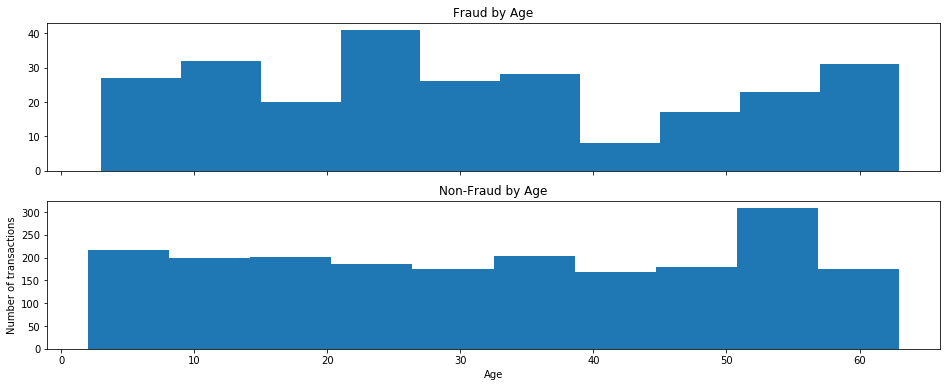

In [12]:
import matplotlib.pyplot as plt

_, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16,6))

ax1.hist(sample_data.Age[sample_data.PotentialFraud == 1])
ax1.set_title('Fraud by Age')

ax2.hist(sample_data.Age[sample_data.PotentialFraud == 0])
ax2.set_title('Non-Fraud by Age')

plt.xlabel('Age')
plt.ylabel('Number of transactions')
plt.show()

The above graphs show a histogram of fraud by age and from the above we can derive that customers in the age group 20-30 are most prone to fraud. Similar to this, there can be other parameters across which this can be visualized to get a better understanding of this data.

### Rule-based Fraud Detection

Fraud is often governed by certain rules which are either regulatory or observed in the historical data. These can be defined and immediately flagged off as a potential fraud to be investigated. 

Below, we demonstrate the use of one such rule which takes into account the transaction country and the time of transaction and flags if off as a potential fraud is the ratio between the two is considered to be suspicious.

In [28]:
import geopy.distance
import numpy as np
from datetime import datetime
import json

coords_1 = (1.3521,103.8198) # Transaction in Singapore
coords_2 = (20.5937,78.9629) # Transaction in India
coords = [coords_1,coords_2]

In [24]:

distance_cur_prev_trans = geopy.distance.vincenty(coords_1, coords_2).km
print("Distance between the countries = "+str(distance_cur_prev_trans)+"km")

f = '%Y-%m-%d %H:%M:%S' # time format
prev_trans_dt = '2017-09-28 15:24:01' # Transaction in Singapore
trans_dt = '2017-09-28 16:24:01' # Transaction in India
trans_dt = datetime.strptime(trans_dt,f)
prev_trans_dt = datetime.strptime(prev_trans_dt,f)
time_diff = trans_dt - prev_trans_dt
time_diff_mins = (time_diff.days * 86400 + time_diff.seconds)/60
print("Time between the transactions = "+str(time_diff_mins)+"mins")

Distance between the countries = 3439.5204333560782km
Time between the transactions = 60.0mins


In [30]:
potentialFraud = 0
fraudReason = []
if (distance_cur_prev_trans > 2000 and time_diff_mins < 100):
    potentialFraud = potentialFraud + 0.6
    fraudReason.append('Transaction in multiple countries in a short duration')
    
# Creating the JSON object to return
final_fraud_json = {}
final_fraud_json['potentialFraud'] = potentialFraud
final_fraud_json['fraudReason'] = fraudReason
final_fraud_json = json.dumps(final_fraud_json)

print("Fraud Reasons ===>")
print(final_fraud_json)

Fraud Reasons ===>
{"fraudReason": ["Transaction in multiple countries in a short duration"], "potentialFraud": 0.6}


You can see that the above rule is something which is logical and applicable and it flags it off as a potential fraud with a high probability.

By studying the historical data, numerous such rules can be applied to flag potential frauds.

Please read our blog post to understand and know more about this : <a href="https://www.justanalytics.com/blog/what-to-look-for-in-a-credit-card-fraud-detection-system">What to look for in a credit card fraud detection system<a>

### Deep Learning Models for Fraud Detection

Deep learning is a broader class of machine learning in which the methods are based on learning data representation rather than task specific algorithms. Credit card fraud is highly based on certain patterns and anomalies observed within the data. This along with the huge volume of transaction data associated calls for a methodology which can deal with the data volume, class imbalance and help learn patterns associated with fraud easily and also be able to adapt over time.

#### Model Training

In order to create a deep learning model, which we chose to be a Dense Neural Network on Tensorflow, we make use of the Keras library in python (pip install keras) to train the model of all customer transaction and demographic data. We also use multiple methods of stratified sampling, mix max scaling, hyperparameter tuning and others to balance classes and speed up the deep learning training process.

For the purpose of the demo, we are going to use the models we have pre-trained and saved out in JSON and H5 formats to score a sample transaction.

#### Model Scoring

We use the above trained model in order to score for transactions happening in real time in order to predict whether they are a potential fraud are not.

In [32]:
import json
from keras.models import model_from_json

############################# load json and create model
json_file = open('..\\05_models\\fraud_dl_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("..\\05_models\\fraud_dl_model.h5")
print("Loaded model from disk.")

# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#########################

c:\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

Using TensorFlow backend.


Loaded model from disk.


In [50]:
# Lets get a sample transaction to score
sample_pred_data = pd.read_csv('..\\99_sample_data\\creditcarddata.csv')
sample_pred_data = sample_pred_data.tail(1)
sample_pred_data = sample_pred_data.iloc[:,0:12]
    
prediction = loaded_model.predict_classes(sample_pred_data)
print("Potential Fraud? : {}".format(str(prediction[0])))

Potential Fraud? : [0]


You can see that the above scoring model is able to pick up a trained model and score for a potential fraud.

The above two methods of rule based system and deep learning models can be combined to give a consolidated potential fraud result for a customer transaction. This result can be useful is flagging a transaction as it occurs and take actions accordingly.

### Conclusion

Fraud detection for credit cards is extremely important and necessary in order to avoid unwanted activities and prevent them from taking place. In order to do that we use a combination of rule based systems and deep learning models which learn from millions of historical customer transactions.